In [1]:
import gym
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
import itertools
import operator
import copy
import time
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms.functional import crop, resize

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class MODEL(nn.Module):

    def __init__(self, input_feature, out_feature):
        super(MODEL, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_feature[0], out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, out_feature)
        )

    def forward(self, x,):
        # for layer in self.model:
        #     x = layer(x)
        #     print(x.size())
        # return x
        return self.model(x)

In [5]:
m = MODEL((4, 84, 84), 4)

import torchsummary

torchsummary.summary(m, input_size=(4, 84, 84), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 20, 20]           8,224
              ReLU-2           [32, 32, 20, 20]               0
            Conv2d-3             [32, 64, 9, 9]          32,832
              ReLU-4             [32, 64, 9, 9]               0
            Conv2d-5             [32, 64, 7, 7]          36,928
              ReLU-6             [32, 64, 7, 7]               0
           Flatten-7                 [32, 3136]               0
            Linear-8                  [32, 512]       1,606,144
              ReLU-9                  [32, 512]               0
           Linear-10                    [32, 4]           2,052
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.45
Forward/backward pass size (MB): 11.33
Params size (MB): 6.43
Estima

In [7]:
N_EPISODE = 1_000_000
BATCH_SIZE = 64
GAMMA = 0.99

EPSILON_MIN = 0.1
EPSILON_DECAY = 1_000_000

LR = 0.00025

UPDATE_MODEL = 10000

CAPACITY = 1_000_000

In [8]:
env = gym.make('Breakout-v0')
env = gym.wrappers.GrayScaleObservation(env)
env = gym.wrappers.FrameStack(env, 4)

In [9]:
frame = env.reset()
image = crop(torch.tensor(np.array(frame)), 30, 7, 180, 146)
image = resize(image, size=[84, 84])
image.shape

torch.Size([4, 84, 84])

In [23]:
# Agent of player

class Agent:
    def __init__(self, render=False):
        self.n_actions = env.action_space.n
        self.state = env.reset()
        self.frame = crop(torch.tensor(self.state), 30, 7, 180, 146)
        self.frame = resize(self.frame, size=[84, 84])
        self.n_observation = self.frame.shape
        self.policy = MODEL(self.n_observation, self.n_actions).to(device=device)
        self.target = MODEL(self.n_observation, self.n_actions).to(device=device)
        for p in self.target.parameters():
            p.requires_grad = False

        # self.optimizer = optim.Adam(self.net.parameters(), lr=LR,)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=LR, momentum=0.95)
        # self.loss_fn = torch.nn.SmoothL1Loss()
        self.loss_fn =  nn.MSELoss()
        self.render = render
        self.replay_memory = deque([], maxlen=10000)
        self.episode_durations = []

    def chooseAction(self, state, epsilon_greedy):
        if np.random.binomial(1, epsilon_greedy) == 1:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                return torch.argmax(self.policy(state)).view(1, 1)

    def play(self, episodes=50_000_000):
        STEP = 0
        episode_step = 0
        # Play for number of episodes
        for i in range(episodes):
            current_state = env.reset()
            # If render is True show the play
            if self.render:
                env.render()
            # Transform the observed state to Tensor
            current_state = torch.tensor(np.array(current_state), dtype=torch.float32, device=device)
            # Crop the state
            current_state = crop(current_state, 30, 7, 180, 146)
            # Resize the observed frame for input model
            current_state = resize(current_state, size=[84, 84]).unsqueeze(0)
            # print(current_state.shape)
            # Play each episode until get to terminate state
            for t in itertools.count():
                # Act
                epsilon_greedy = EPSILON_MIN + max(EPSILON_DECAY - STEP, 0) / EPSILON_DECAY * (1 - EPSILON_MIN)
                action = self.chooseAction(current_state, epsilon_greedy)
                # Perform Act
                next_state, reward, terminated, truncated = env.step(action.item())
                if self.render:
                    env.render()
                # done = terminated or truncated
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
                    next_state = crop(next_state, 30, 7, 180, 146)
                    next_state = resize(next_state, size=[84, 84]).unsqueeze(0)

                reward = torch.tensor(reward, device=device).unsqueeze(0)
                reward = torch.clip(reward, -1, 1)
                # Remember
                self.replay_memory.append((current_state, action, reward, next_state))

                # Update Second Model
                if STEP % UPDATE_MODEL == 0:
                    self.target.load_state_dict(self.policy.state_dict())
                # Learn
                if len(self.replay_memory) > BATCH_SIZE * 10:
                    # Sample From Memory
                    minibatch = random.sample(self.replay_memory, BATCH_SIZE)

                    curr_state_batch = torch.cat(tuple(map(operator.itemgetter(0), minibatch )))
                    action_batch = torch.cat(tuple(map(operator.itemgetter(1), minibatch )))
                    reward_batch = torch.cat(tuple(map(operator.itemgetter(2), minibatch )))
                    next_state_batch = tuple(map(operator.itemgetter(3), minibatch ))
                    # Here if we don
                    mask_next_state = []
                    not_none_next_state = []
                    for state in next_state_batch:
                        if state is not None:
                            mask_next_state.append(True)
                            not_none_next_state.append(state)
                        else:
                            mask_next_state.append(False)

                    mask_next_state = torch.tensor(mask_next_state, device=device)
                    not_none_next_state = torch.cat(not_none_next_state)

                    # Get TD Estimate
                    estimation = self.policy(curr_state_batch).gather(1, action_batch)
                    # Get TD Target
                    with torch.no_grad():
                        # The state value for next state
                        next_state_values = torch.zeros(BATCH_SIZE, device=device)
                        # Selecting best action for next state with online model
                        next_state_estimation= self.policy(not_none_next_state)
                        select_action = torch.argmax(next_state_estimation, dim=1).unsqueeze(1)
                        # With best action compute state value for next state using target network
                        next_state_q_values = self.target(not_none_next_state).gather(1, select_action).squeeze(1)
                        next_state_values[mask_next_state] = next_state_q_values
                        # Calculate target estimation
                        target_value = (reward_batch + (GAMMA * next_state_values)).unsqueeze(1)

                    # Backpropagation loss through Q_online
                    loss = self.loss_fn(estimation, target_value)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                STEP += 1
                episode_step += 1

                current_state = next_state

                if terminated:
                    self.episode_durations.append(episode_step + 1)
                    episode_step = 0
                    break



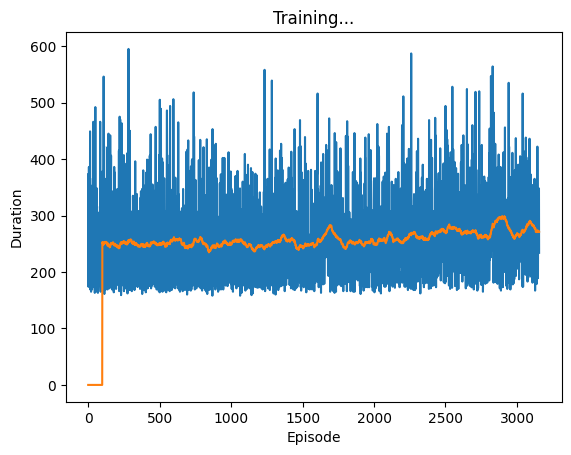

<Figure size 640x480 with 0 Axes>

In [ ]:
ag = Agent(render=True)
ag.play(N_EPISODE)

In [14]:
env.close()